In [1]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(dz)
    om = observation_models.LinearObservationModel(dx, dz, noise_x=1.)
    
    if init_w_pca == 1:
        om.pca_init(x_tr, smooth_window=smooth_window)
        
    ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(dz)
    om_hs = observation_models.HCCovObservationModel(dx, dz, du)
    if init_w_pca == 1:
        om_hs.pca_init(x_tr, smooth_window=20)
    hs_model = StateSpaceEM(x_tr, observation_model=om_hs, state_model=sm_hs)
    hs_model.run()
    
    return hs_model

In [2]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_airfoil_e1()

In [3]:
smooth_window = 20
dz, du = observation_models.recommend_dims(x_tr, smooth_window=20)

In [41]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_airfoil_e1(train_ratio=.75)
ssm_em_hsk = train_linear_SSM(x_tr, dz, init_w_pca=True, smooth_window=smooth_window)
ssm_em_hsk.save(model_name='ssm_em_lin_airfoil', path='../../data/models/', overwrite=True)

Iteration 2 - llk=-9012.2
Iteration 4 - llk=-2888.3
Iteration 6 - llk=2717.5
Iteration 8 - llk=7096.1
Iteration 10 - llk=9034.1
Iteration 12 - llk=10506.4
Iteration 14 - llk=11768.2
Iteration 16 - llk=12202.7
Iteration 18 - llk=12440.0
Iteration 20 - llk=12601.1
Iteration 22 - llk=12726.2
Iteration 24 - llk=12834.1
Iteration 26 - llk=12934.8
Iteration 28 - llk=13033.3
Iteration 30 - llk=13130.8
Iteration 32 - llk=13225.4
Iteration 34 - llk=13313.2
Iteration 36 - llk=13390.8
Iteration 38 - llk=13457.1
Iteration 40 - llk=13512.7
Iteration 42 - llk=13559.3
Iteration 44 - llk=13598.6
Iteration 46 - llk=13632.1
Iteration 48 - llk=13660.8
EM did converge.


In [ ]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_airfoil_e1(train_ratio=.75)
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=True, smooth_window=smooth_window)
ssm_em_hsk.save(model_name='ssm_em_hsk_airfoil', path='../../data/models/', overwrite=True)

Iteration 2 - llk=5670.5
Iteration 4 - llk=9745.1
Iteration 6 - llk=11317.3
Iteration 8 - llk=11909.1


In [8]:
ssm_em_hsk = load_model(model_name='ssm_em_hsk_airfoil', path='../../data/models/')
ssm_em_lin = load_model(model_name='ssm_em_lin_airfoil', path='../../data/models/')

In [43]:
pred_hsk = ssm_em_hsk.compute_predictive_density(x_te)
pred_lin = ssm_em_lin.compute_predictive_density(x_te)

In [44]:
ssm_em_lin.compute_predictive_log_likelihood(x_te)

45599.57975630142

In [45]:
ssm_em_hsk.compute_predictive_log_likelihood(x_te)

45397.05301356221

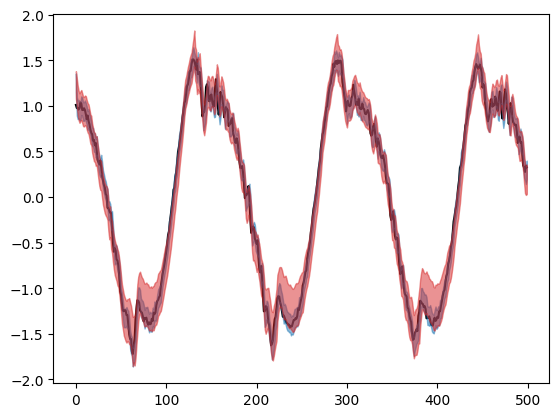

In [37]:
pyplot.rcdefaults()
mu_hsk, std_hsk = pred_hsk.mu, numpy.sqrt(pred_hsk.Sigma.diagonal(axis1=1, axis2=2))
mu_lin, std_lin = pred_lin.mu, numpy.sqrt(pred_lin.Sigma.diagonal(axis1=1, axis2=2))

idx = -5
T_max = 500
fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.plot(x_te[:T_max,idx], 'k')
#pyplot.plot(mu_hsk[:T_max,idx], color='C1')
pyplot.fill_between(range(T_max), mu_hsk[:T_max,idx] - 1.68 * std_hsk[:T_max,idx], mu_hsk[:T_max,idx] + 1.68 * std_hsk[:T_max,idx], color='C3', alpha=.5, zorder=9)
pyplot.fill_between(range(T_max), mu_lin[:T_max,idx] - 1.68 * std_lin[:T_max,idx], mu_lin[:T_max,idx] + 1.68 * std_lin[:T_max,idx], color='C0', alpha=.5, zorder=7)

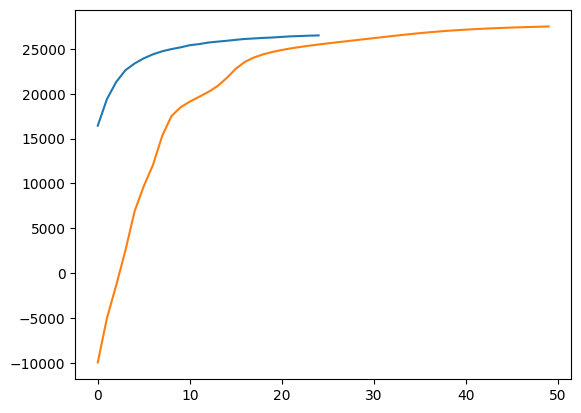

In [30]:
pyplot.plot(ssm_em_hsk.llk_list[2:])
pyplot.plot(ssm_em_lin.llk_list[2:])

In [40]:
x_te.shape

(6286, 11)